In [1]:
from IPython.display import display
from ipywidgets import *
from IPython.display import Image
from matplotlib import pyplot as plt
import math
import random
import subprocess
from ctypes import *

lib = '/home/kokamido/Рабочий стол/диплом/ipython/cfunc_low.so'
cfunc = cdll.LoadLibrary(lib)

cfunc.draw_noisy_curve.restype= POINTER(POINTER(c_double))
cfunc.draw_noisy_curve.argtype = [c_double, c_double, c_double, c_double, c_double, c_double, c_int]

cfunc.draw_curve.restype= POINTER(POINTER(c_double))
cfunc.draw_curve.argtype = [c_double, c_double, c_double, c_double, c_double, c_int]

cfunc.find_cycle.restype= POINTER(POINTER(c_double))
cfunc.find_cycle.argtype = [c_double, c_double, c_double, c_double, c_int]

In [2]:
p = 3
Step = 0.0001
q = 1
def singular_point_x():
    return 1
def singular_point_y():
    return 1
noise_lvl = 0.002

In [3]:
def f(x,y):
    return 1-x*y

In [4]:
def g(x,y):
    return p*y*(x-(1+q)/(q+y))

In [5]:
def k1(x0,y0):
    return Step*f(x0,y0)

In [6]:
def l1(x0,y0):
    return Step*g(x0,y0)

In [7]:
def k2(x0,y0):
    x = x0+k1(x0,y0)/2
    y = y0+l1(x0,y0)/2 
    return Step*f(x,y)

In [8]:
def l2(x0,y0):
    x = x0+k1(x0,y0)/2
    y = y0+l1(x0,y0)/2
    return Step*g(x,y)

In [9]:
def k3(x0,y0):
    x = x0+k2(x0,y0)/2
    y = y0+l2(x0,y0)/2
    return Step*f(x,y)

In [10]:
def l3(x0,y0):
    x = x0+k2(x0,y0)/2
    y = y0+l2(x0,y0)/2
    return Step*g(x,y)

In [11]:
def k4(x0,y0):
    x = x0+k3(x0,y0)
    y = y0+l3(x0,y0)
    return Step*f(x,y)

In [12]:
def l4(x0,y0):
    x = x0+k3(x0,y0)
    y = y0+l3(x0,y0)
    return Step*g(x,y)

In [13]:
def rk(pair):
    x0 = float(pair[0])
    y0 = float(pair[1])
    x = pair[0] +1/6*(k1(x0,y0)+2*k2(x0,y0)+2*k3(x0,y0)+k4(x0,y0))
    y = pair[1] +1/6*(l1(x0,y0)+2*l2(x0,y0)+2*l3(x0,y0)+l4(x0,y0))
    return [x,y]

In [14]:
def curve(x0,y0,n):
    res_x = list()
    res_y = list()
    bufferVals = POINTER(POINTER(c_double))
    bufferVals = cfunc.draw_curve(c_double(Step),
                                        c_double(p),c_double(q),
                                        c_double(x0),c_double(y0),
                                        c_int(n))
    for i in range(0,n):
        res_x.append(bufferVals[0][i])
        res_y.append(bufferVals[1][i])
    cfunc.free_crv_memory()
    return[res_x,res_y]

In [15]:
def curve_reverse(x0,y0,n):
    global Step
    buf = Step
    Step = -buf
    i = 0
    res_x = list()
    res_y = list()
    while i < n:
        res_x.append(x0)
        res_y.append(y0)
        current = rk([x0,y0])
        x0 = current[0]
        y0 = current[1]
        i+=1
    Step = buf
    return[res_x,res_y]

In [16]:
def curves_y(start_y,end_y,x,step,rk_iter,color='c',lw=1):
    y = start_y
    while y < end_y:
        current_curve = curve(x,y,rk_iter)
        plt.plot(current_curve[0],current_curve[1],color,linewidth=lw)
        y+=step

In [17]:
def curves_x(start_x,end_x,y,step,rk_iter):
    x = start_x
    while x < end_x:
        current_curve = curve(x,y,rk_iter)
        plt.plot(current_curve[0],current_curve[1],'c',linewidth=5)
        x+=step

In [18]:
def curves_circle(num, r,rk_iter, color='c',lw=1):
    for i in range(1,num):
        current_curve = curve(1+r*math.cos(2*math.pi/num*i),1+r*math.sin(2*math.pi/num*i),rk_iter)
        plt.plot(current_curve[0],current_curve[1],color,linewidth=lw)

In [19]:
def curves_circle_rev(num, r,rk_iter, color='c',lw=1):
    for i in range(1,num):
        current_curve = curve_reverse(1+r*math.cos(2*math.pi/num*i),1+r*math.sin(2*math.pi/num*i),rk_iter)
        plt.plot(current_curve[0],current_curve[1],color,linewidth=lw)

In [20]:
def euclidean_range(x0,y0,x1,y1):
    return math.sqrt(math.pow(x0-x1,2)+math.pow(y0-y1,2))


def find_cycle(eps,iterations=100000):
    res_x = list()
    res_y = list()
    print("i am c")
    bufferVals = POINTER(POINTER(c_double))
    bufferVals = cfunc.find_cycle(c_double(p), c_double(q),c_double(Step),
                                  c_double(eps), c_int(iterations))
    n = int(bufferVals[0][0])
    for i in range(1,n):
        res_x.append(bufferVals[0][i])
        res_y.append(bufferVals[1][i])
    cfunc.free_crv_memory()
    return[res_x,res_y]        

def F11(x,y):
    return -y

def F12(x,y):
    return -x

def F21(x,y):
    return p*y

def F22(x,y):
    return p*x-2*p/math.pow((1+y),2)

# в качестве z0,z1 берутся 0, 1 или 1,0
def vector_for_monodromy(z0,z1,cycle): #cycle[0], cycle[1]-- координаты точки из цикла, cycle[2]-- количество точек в цикле
    #i=0
    #z00 = z0 + Step*(F11(x[0], y[0])*z0 + F12(x[0], y[0])*z1)
    #z11 = z1 + Step*(F11(x[0], y[0])*z0 + F12(x[0], y[0])*z1)
    #pair = [z00, z11]
    x = cycle[0]
    y = cycle[1]
    i=0
    z00 = z0
    z11 = z1
    while i<len(cycle[1]):
        #pair = euler(pair, x[i], y[i])
        z0 = z00
        z1 = z11
        z00 = z0 + Step*(F11(x[i], y[i])*z0 + F12(x[i], y[i])*z1)
        z11 = z1 + Step*(F21(x[i], y[i])*z0 + F22(x[i], y[i])*z1)
        i+=1
    pair = [z00, z11]
    return pair

def multiplier(vector1, vector2):
    a = vector1[0]
    b = vector1[1]
    c = vector2[0]
    d = vector2[1]
    print([[a,b],[c,d]])
    discr = (a+d)*(a+d)-4*(a*d-b*c)
    if discr>=0:
        lambda1 = (a+d+math.sqrt(discr))*0.5
        lambda2 = (a+d-math.sqrt(discr))*0.5
    else:
        lambda1 = 0
        lambda2 = 0
    return [lambda1, lambda2]

def get_multiplier():
    cycle = find_cycle(0.0001)
    vector_ab = vector_for_monodromy(0,1,cycle)
    vector_cd = vector_for_monodromy(1,0,cycle)
    return multiplier(vector_cd, vector_ab)
    

def norm(vec):
    nor = euclidean_range(0,0,vec[0],vec[1])
    return[vec[0]/nor,vec[1]/nor]

import cmath
def eugenvalues(M):
    #print(M)
    disc_sqrt = cmath.sqrt(math.pow(M[0][0]+M[1][1],2)-4*(M[0][0]*M[1][1]-M[1][0]*M[0][1]))
    if(disc_sqrt.imag > 0):
        print("img = "+str(disc_sqrt.imag))
    disc_sqrt = disc_sqrt.real
    return[(M[0][0]+M[1][1]+disc_sqrt)/2, (M[0][0]+M[1][1]-disc_sqrt)/2]

def is_stable(cycle):
    a_b = Euler([1,0],cycle)
    c_d = Euler([0,1],cycle)
    return Andronov_Hopf_condition([[a_b[0],a_b[1]],[c_d[0],c_d[1]]])#([[a_b[0],c_d[0]],[a_b[1],c_d[1]]])

In [21]:
import random
import math
random.seed()
def normal_dist_random_values():
    x = random.random()
    y = random.random()
    
    a = math.sqrt(-2*math.log(x))*math.cos(2*math.pi*y)
    b = math.sqrt(-2*math.log(x))*math.sin(2*math.pi*y)
    return [a,b]
noise_lvl = 0.01

def noisy_curve(x0,y0,n):
    res_x = list()
    res_y = list()
    bufferVals = POINTER(POINTER(c_double))
    bufferVals = cfunc.draw_noisy_curve(c_double(noise_lvl),c_double(Step),
                                        c_double(p),c_double(q),
                                        c_double(x0),c_double(y0),
                                        c_int(n))
    for i in range(0,n):
        res_x.append(bufferVals[0][i])
        res_y.append(bufferVals[1][i])
    cfunc.free_crv_memory()
    return[res_x,res_y]


def avg(list_arg):
    return sum(list_arg)/len(list_arg)

def expectancy(crv):
    return [avg(crv[0]),avg(crv[1])]

from functools import reduce
def dispersion(crv):
    exp = expectancy(crv)
    centr_curve = [map(lambda x: x-exp[0],crv[0]), map(lambda x: x-exp[1],crv[1])]
    return [reduce(lambda y,x: x*x+y,centr_curve[0])/len(crv[0]),reduce(lambda y,x: x*x+y,centr_curve[1])/len(crv[0])]

In [22]:
def normalize(vec):
    mod = euclidean_range(0,0,vec[0],vec[1])
    return[vec[0]/mod,vec[1]/mod]
def time_row(vals):
    times = [i*Step for i in range(0,len(vals))]
    plt.plot(times,vals)
def get_W_matrix():
    w11 = (-p*p-p*q*q-p*q-q*q-2*q-1)/(2*q*p*(p-q-1))
    w12=w21=(p*p*q+p*p+q*q+2*q+1)/(2*q*p*(p-q-1))
    w22=-((q+1)*(p*p*q+p*p+p*q+q+1))/(2*q*p*(p-q-1))
    return[[w11,w12],[w21,w22]]

In [23]:
#
#plt.xlim(left_bound, right_bound)
#plt.ylim(bottom_bound,top_bound)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0]=10
fig_size[1]=10
#

In [24]:
#Интегрирование
def trap_method(x0,y0,x1,y1,func):
    return (func(x0,y0)+func(x1,y1))/2*Step

In [25]:
def p_vec(x,y):
    norm = math.sqrt(g(x,y)*g(x,y)+f(x,y)*f(x,y))
    return [-g(x,y)/norm, f(x,y)/norm]
def a_vec(x,y):
    current_p = p_vec(x,y)
    p1 = current_p[0]
    p2 = current_p[1]
    summ = F21(x,y)+F12(x,y)
    return p1*(2*p1*F11(x,y)+p2*summ)+p2*(2*p2*F22(x,y)+p1*summ)
def r(x0,y0,x1,y1):
    return math.pow(math.e, trap_method(x0,y0,x1,y1,a_vec))
def phi(r0,r1):
    return (1/r0+1/r1)/2*Step

In [26]:
def get_m_list(cyc):
    rs = list()
    rs.append(1)
    phis = list()
    phis.append(0)
    for i in range(0,len(cyc[0])-1):
        rs.append(rs[-1]*r(cyc[0][i],cyc[1][i],cyc[0][i+1],cyc[1][i+1]))
        phis.append(phis[-1]+phi(rs[-2],rs[-1]))
    c = rs[-1]*phis[-1]/(1-rs[-1])
    ms = list()
    for i in range(0, len(rs)):
        ms.append(rs[i]*(c+phis[i]))
    return ms

In [27]:
def AAA(q,m,p0,p1):
    return [q*noise_lvl*p0*math.sqrt(2*m),q*noise_lvl*p1*math.sqrt(2*m)]
def get_dp(cyc,sens=1.163):
    ms = get_m_list(cyc)
    res_plus = [list(),list()]
    res_minus = [list(),list()]
    for i in range(0, len(cyc[0])-1):
        cur_p = p_vec(cyc[0][i],cyc[1][i])
        p0 = cur_p[0]
        p1 = cur_p[1]
        kek = AAA(sens,ms[i],p0,p1)
        res_plus[0].append(cyc[0][i]+kek[0])
        res_plus[1].append(cyc[1][i]+kek[1])
        res_minus[0].append(cyc[0][i]-kek[0])
        res_minus[1].append(cyc[1][i]-kek[1])
    return{'plus' : res_plus, 'minus' : res_minus, 'M' : max(ms), 'ms':ms}

In [28]:
p=1.11
q=0.1
noise_lvl = 0.000065
Step = 0.001
cycl = get_cycle()
res = get_dp(cycl,sens=2.4)
crv = noisy_curve(cycl[0][0],cycl[1][0],100000)
minus = res['minus']
plus = res['plus']
print(res['M'])
plt.plot(crv[0],crv[1], c='c')
plt.plot(plus[0],plus[1],c='m', lw=1)
plt.plot(minus[0],minus[1],c='m' ,lw=1)
plt.plot(cycl[0],cycl[1],c='r',lw=1)
plt.show()

NameError: name 'get_cycle' is not defined

66.72451133023176


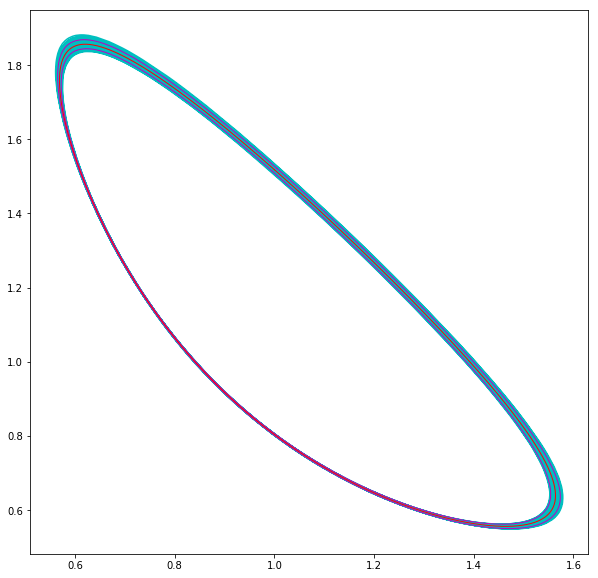

In [66]:
p=1.5
q=0.4
noise_lvl = 0.00045
Step = 0.001
cycl = get_cycle()
res = get_dp(cycl,sens=2.4)
crv = noisy_curve(cycl[0][0],cycl[1][0],1000000)
minus = res['minus']
plus = res['plus']
print(res['M'])
plt.plot(crv[0],crv[1], c='c')
plt.plot(plus[0],plus[1],c='m', lw=1)
plt.plot(minus[0],minus[1],c='m' ,lw=1)
plt.plot(cycl[0],cycl[1],c='r',lw=1)
plt.show()

347.67577106269914


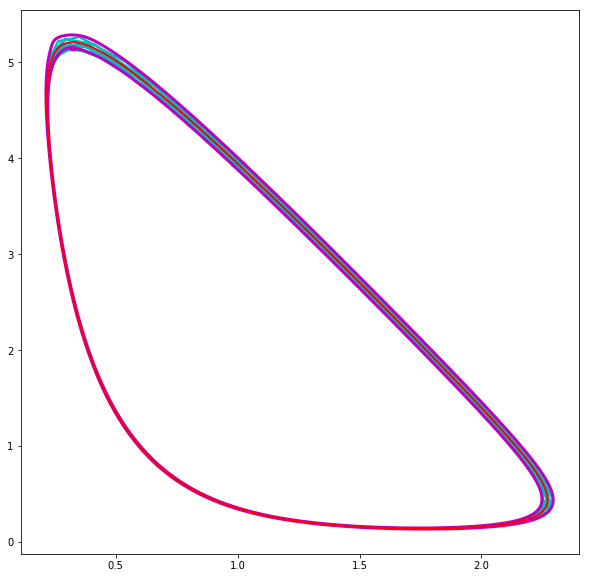

In [35]:
p=3
q=1
noise_lvl = 0.0025
Step = 0.001
cycl = get_cycle()
res = get_dp(cycl)
crv = noisy_curve(cycl[0][0],cycl[1][0],100000)
res_crv = [list(),list()]
for i in range(0 ,len(crv[0])):
    if i%150 == 0:
        res_crv[0].append(crv[0][i])
        res_crv[1].append(crv[1][i])
minus = res['minus']
plus = res['plus']
print(res['M'])
plt.plot(res_crv[0],res_crv[1], 'c')
plt.plot(plus[0],plus[1],c='m', lw=3)
plt.plot(minus[0],minus[1],c='m' ,lw=3)
plt.plot(cycl[0],cycl[1],c='r',lw=2)
plt.show()

P = 2.02


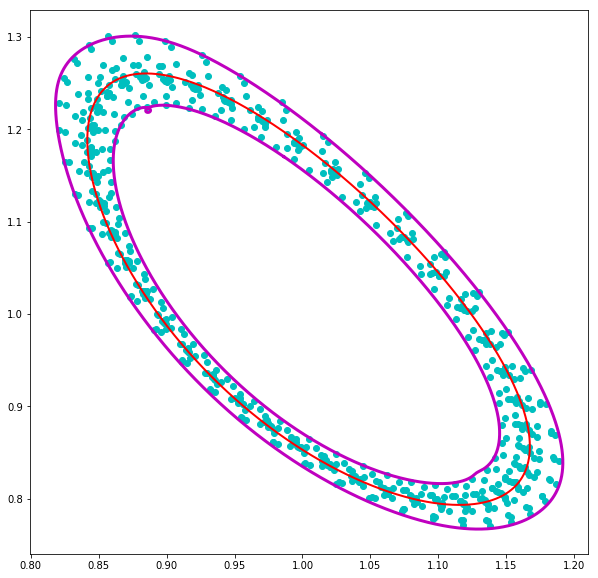

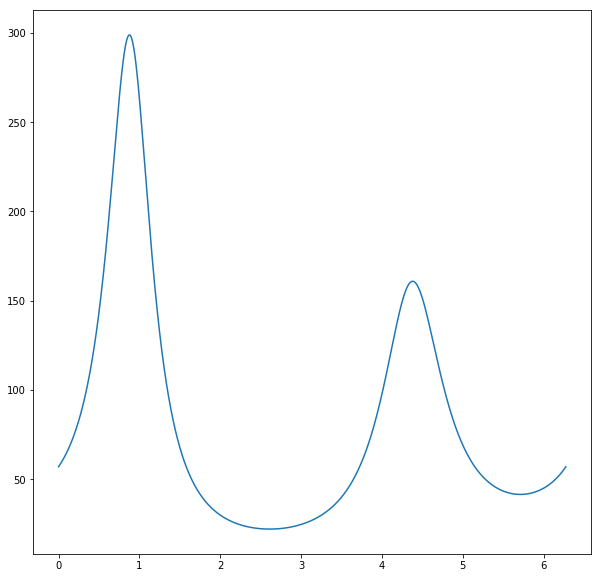

P = 2.32


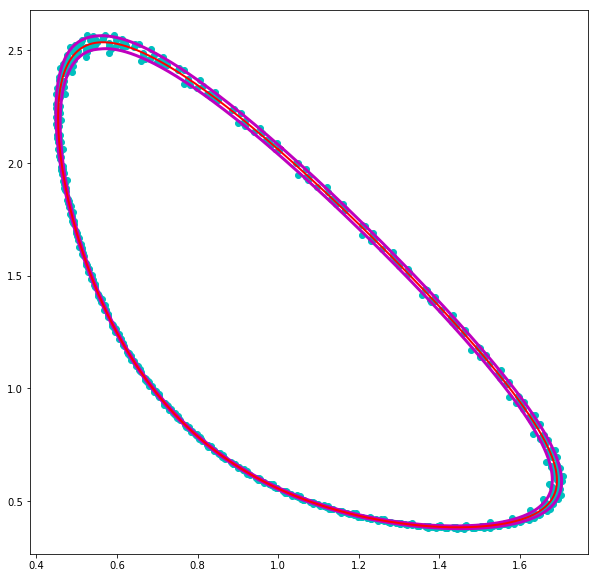

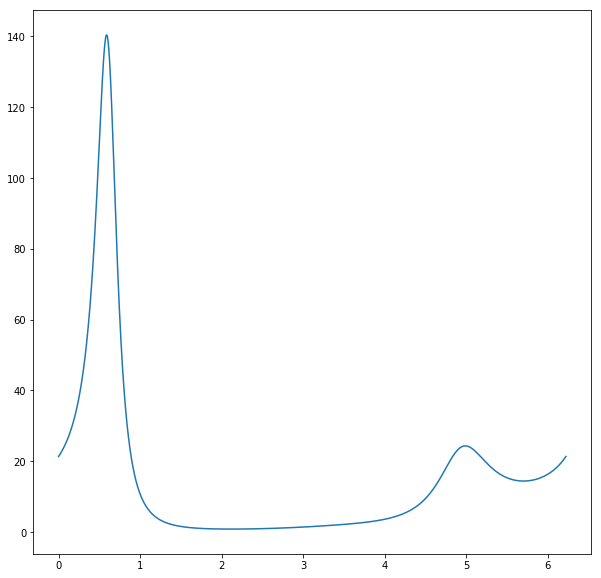

P = 2.62


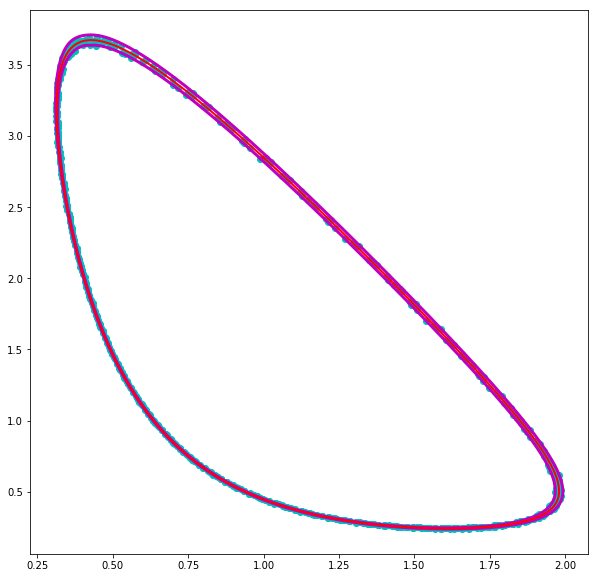

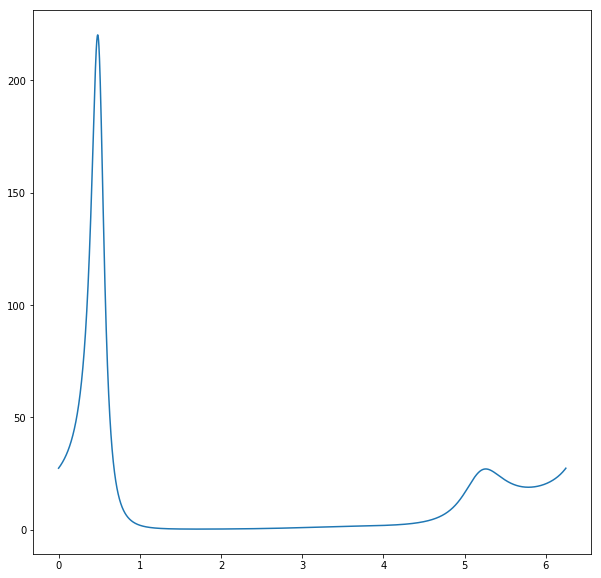

P = 2.92


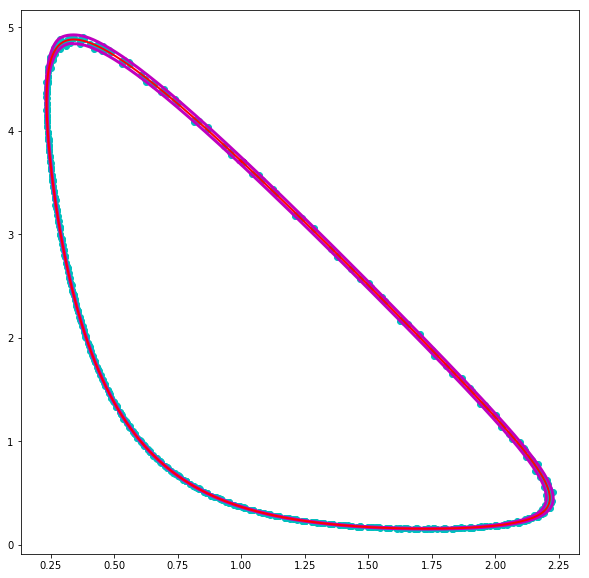

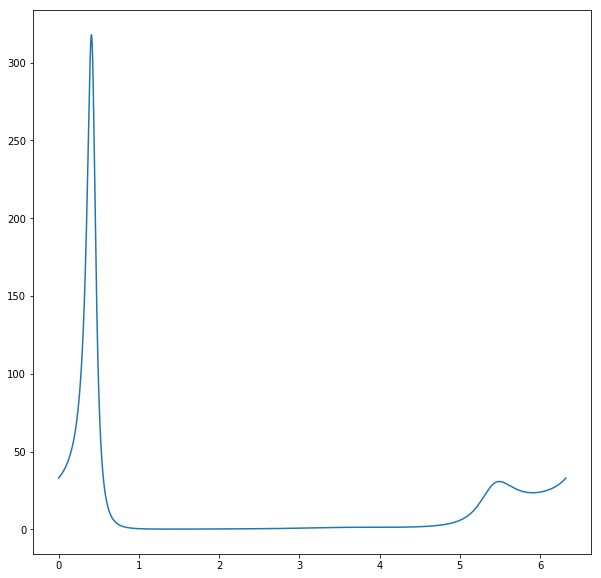

P = 3.2199999999999998


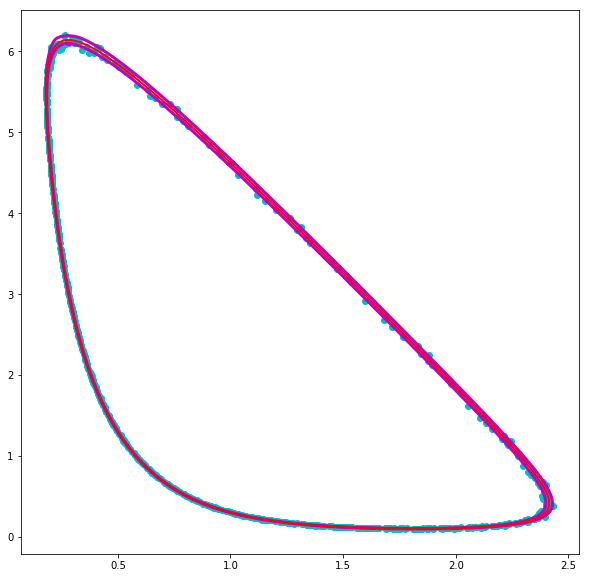

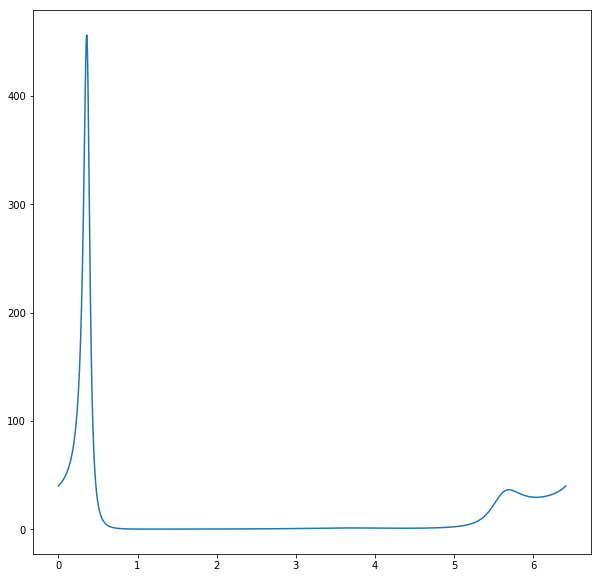

P = 3.5199999999999996


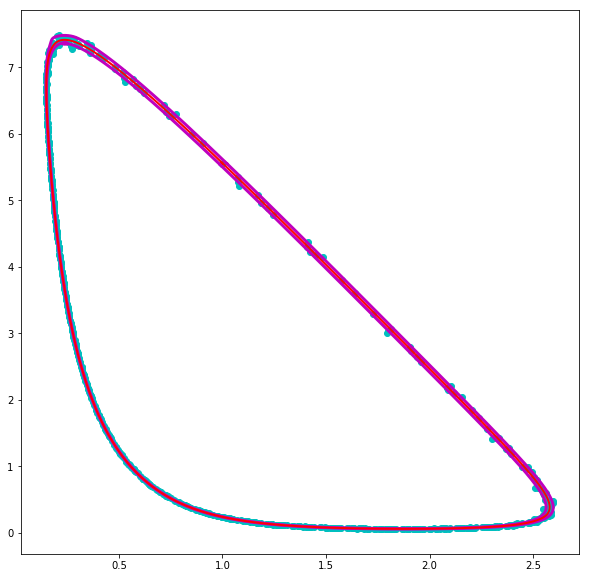

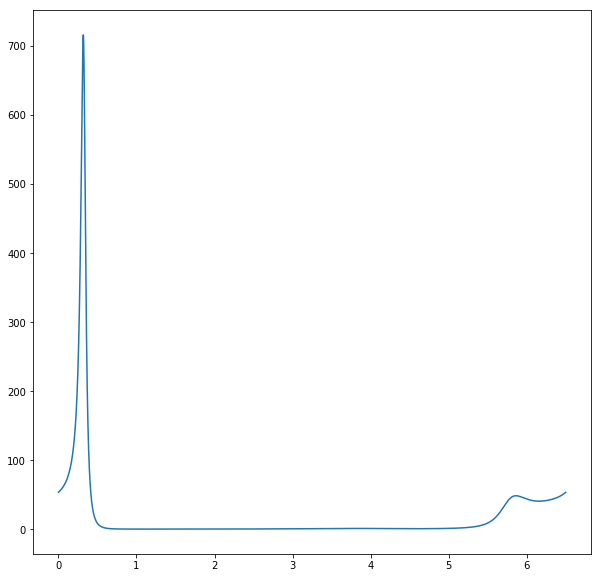

P = 3.8200000000000003


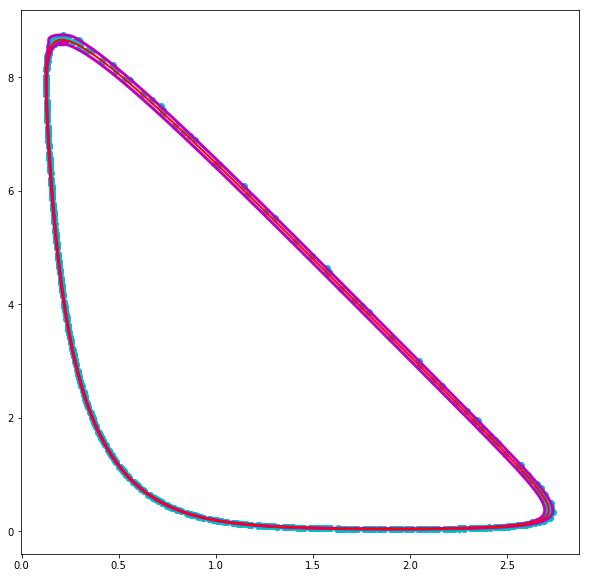

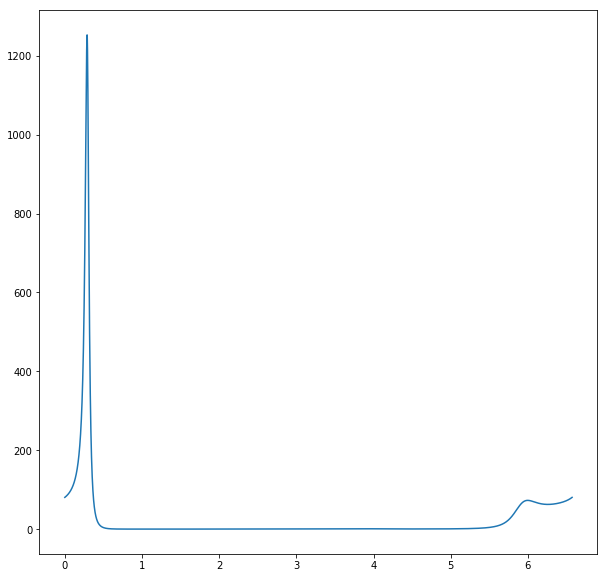

P = 4.12


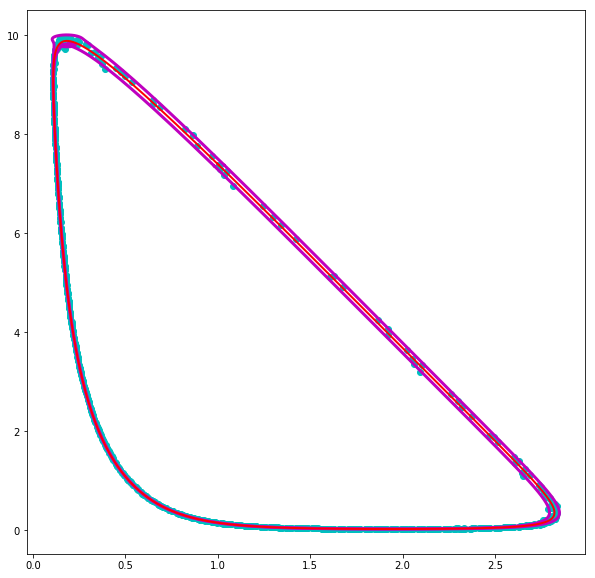

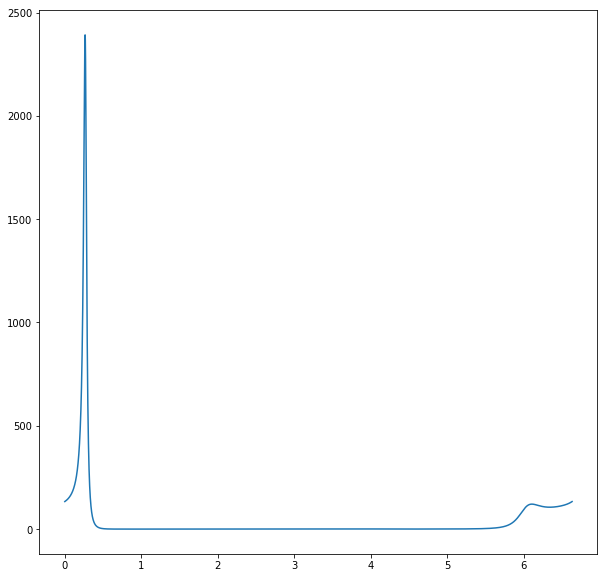

P = 4.42


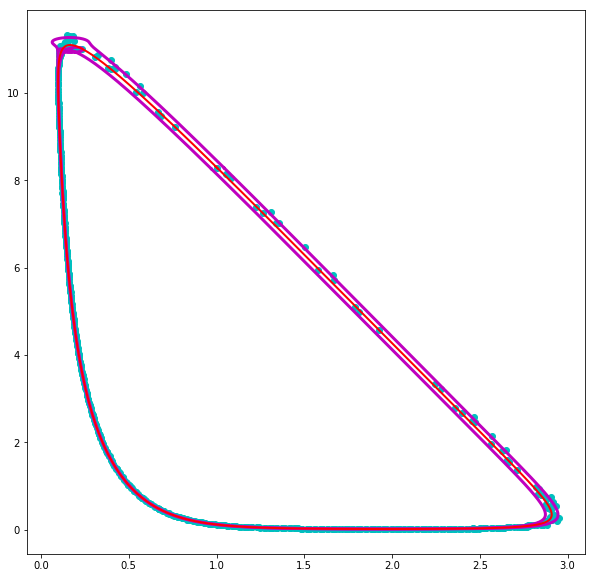

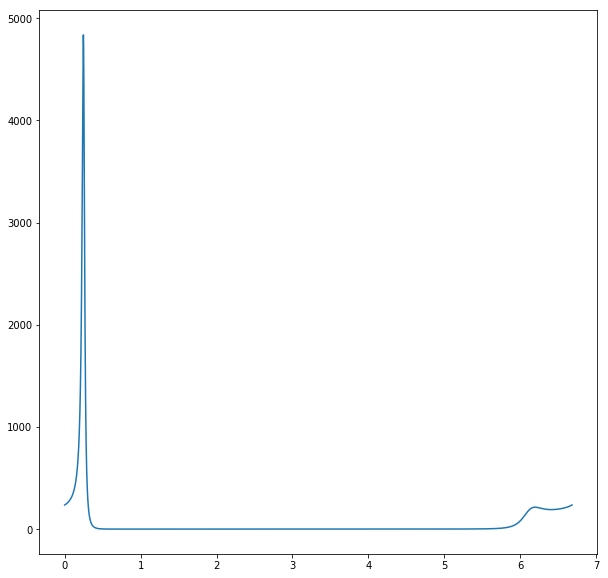

P = 4.72


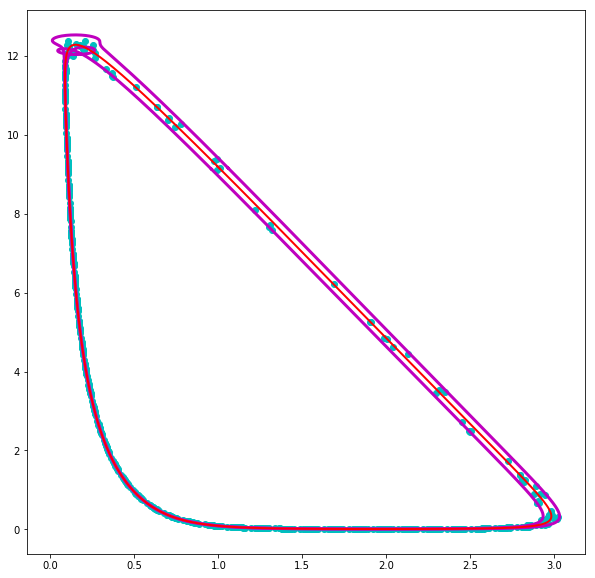

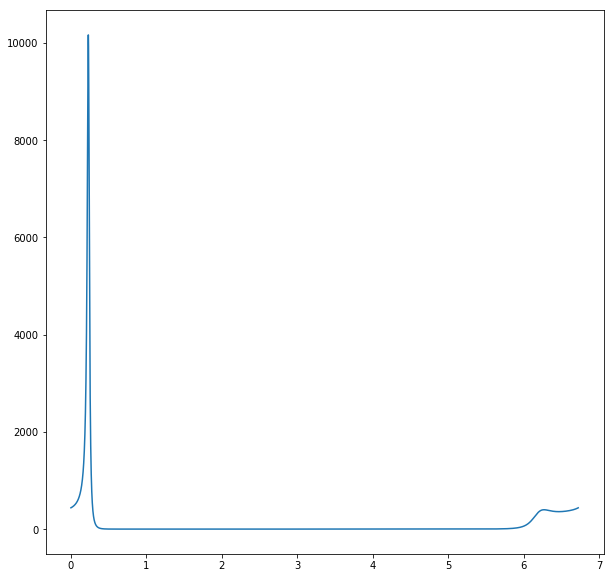

In [35]:
q=1
noise_lvl = 0.0015
Step = 0.001
for k in range(1,11):
    p=1.72+k*0.3
    print("P = "+str(p))
    cycl = find_cycle(0.0001)
    res = get_dp(cycl)
    crv = noisy_curve(cycl[0][0],cycl[1][0],100000)
    res_crv = [list(),list()]

    for i in range(0 ,len(crv[0])-1):
        if i%150 == 0:
            res_crv[0].append(crv[0][i])
            res_crv[1].append(crv[1][i])
    minus = res['minus']
    plus = res['plus']

    plt.plot(res_crv[0],res_crv[1], 'co')
    plt.plot(plus[0],plus[1],c='m', lw=3)
    plt.plot(minus[0],minus[1],c='m' ,lw=3)
    plt.plot(cycl[0],cycl[1],c='r',lw=2)
    plt.show()
    plt.plot([i*0.001 for i in range(0,len(res['ms']))],res['ms'])
    plt.show()

P = 1.82
P = 1.92
P = 2.02
P = 2.12
P = 2.2199999999999998
P = 2.3200000000000003
P = 2.42
P = 2.52
P = 2.62
P = 2.7199999999999998
P = 2.8200000000000003
P = 2.92
P = 3.02
P = 3.12
P = 3.2199999999999998
P = 3.3200000000000003
P = 3.42
P = 3.52
P = 3.62
P = 3.7199999999999998
P = 3.8200000000000003
P = 3.92
P = 4.0200000000000005
P = 4.12
P = 4.22
P = 4.32
P = 4.42
P = 4.5200000000000005
P = 4.62
P = 4.72


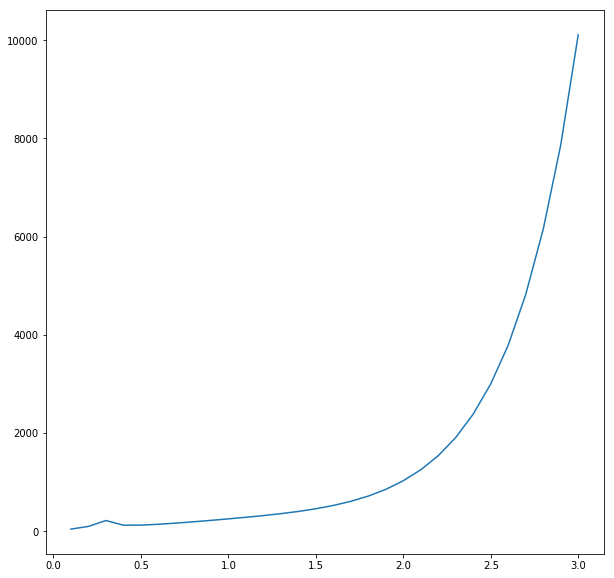

In [53]:
q=1
noise_lvl = 0.0015
Step = 0.001
MS = list()
for k in range(1,31):
    p=1.72+k*0.1
    print("P = "+str(p))
    cycl = get_cycle()
    res = get_dp(cycl)
    crv = noisy_curve(cycl[0][0],cycl[1][0],100000)
    res_crv = [list(),list()]

    for i in range(0 ,len(crv[0])-1):
        if i%150 == 0:
            res_crv[0].append(crv[0][i])
            res_crv[1].append(crv[1][i])
    MS.append(res['M'])
plt.plot([i*0.1 for i in range(1,31)],MS)
plt.show()

0.004979478950823735
0.004316495876054205
0.0037878315541459706
0.0033583282207718668
0.003003824339753436
0.002707226354573544
0.0024561373734064418
0.0022413718824225715
0.002055994819530005
0.0018946831268706887
0.0017532906533106463
0.0016285452073643292
0.0015178337380281626
0.0014190471196902088
0.001330466352465809
0.0012506779539460666
0.0011785101585786162
0.001112984306208098
0.001053277337459857
0.0009986926880696245
0.0009486372111653374
0.0009026031359269382
0.0008601535190153609
0.0008209104593772665
0.0007845457682837953
0.0007507731207854196
0.0007193416889970106
0.0006900310639279539
0.0006626467002657233
0.0006370163693198982
0.0006129871600311088
0.0005904228457289662
0.0005692016858052096
0.0005492146871080017
0.0005303638870932659
0.000512561134969225
0.0004957268480485499
0.00047978901757605996
0.00046468240202357514
0.00045034769452589885
0.00043673095855312205
0.0004237829401392279
0.00041145867684844184
0.0003997170057763455
0.0003885201791606896
0.000377833565

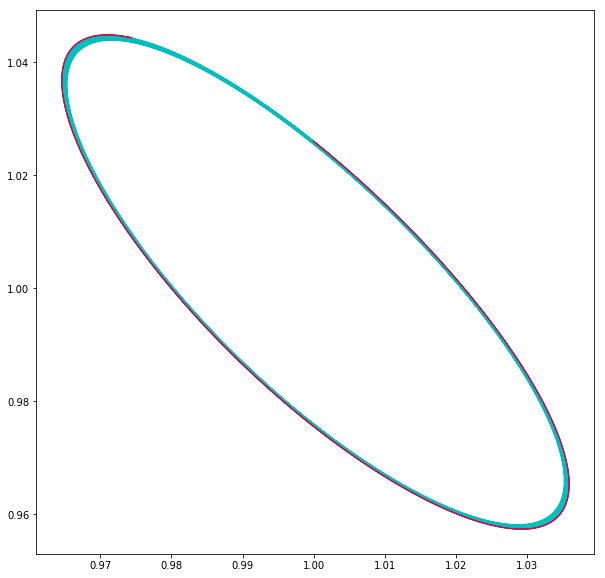

In [42]:
p=1.5
q=0.5
noise_lvl = 0.000000001
Step = 0.0001
cycl = find_cycle(0.0001,iter=100000)
res = get_dp(cycl,sens=2.4)
crv = noisy_curve(cycl[0][0],cycl[1][0],1000000)
minus = res['minus']
plus = res['plus']
print(res['M'])
plt.plot(crv[0],crv[1], c='c')
plt.plot(plus[0],plus[1],c='m', lw=1)
plt.plot(minus[0],minus[1],c='m' ,lw=1)
plt.plot(cycl[0],cycl[1],c='r',lw=1)
plt.show()

7
building curve
processing curve
28.81337368445171
9.247481417562839e+33


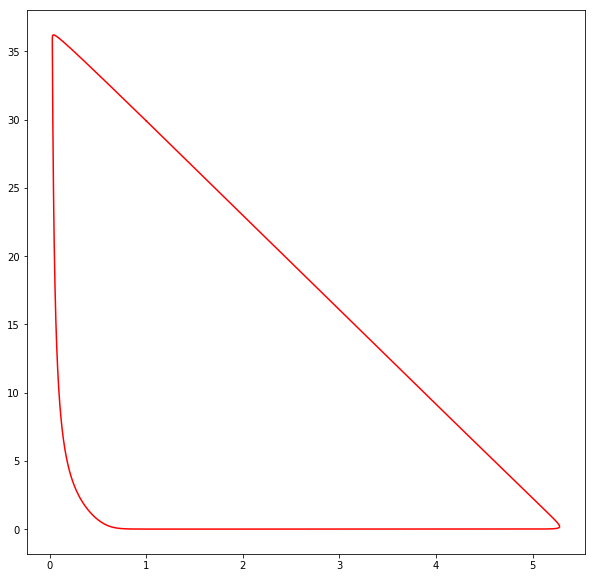

1596256


In [82]:
#Это рисовать портреты
buf = p
#p = 1.133329961035
p=7
q=0.5
Step = 0.00001
#curves_y(0.985, 0.995, 0.99, 0.005, 4000,color='m', lw=1)
#curves_y(1.01, 1.02, 1.01, 0.005, 10000)
print(p)
cyc = find_cycle(0.001,iterations=10000000)
res = get_dp(cyc)
print(res['M'])
plt.plot(cyc[0],cyc[1],c='r')
#plt.show()
#p = 1.133329961036
#cyc = find_cycle(0.01,iterations=10000000)
#print(get_dp(cyc)['M'])
#plt.plot(cyc[0],cyc[1],c='m')
plt.show()
print(len(res['ms']))
    #curves_circle(2,0.01,10000000,color='c')
    
    #cyc = find_cycle(0.001)
    #plt.plot(cyc[0],cyc[1],c='m')
    #plt.show()
    #p = p+0.000000000001
p = buf


i am c
0.9707915476657282


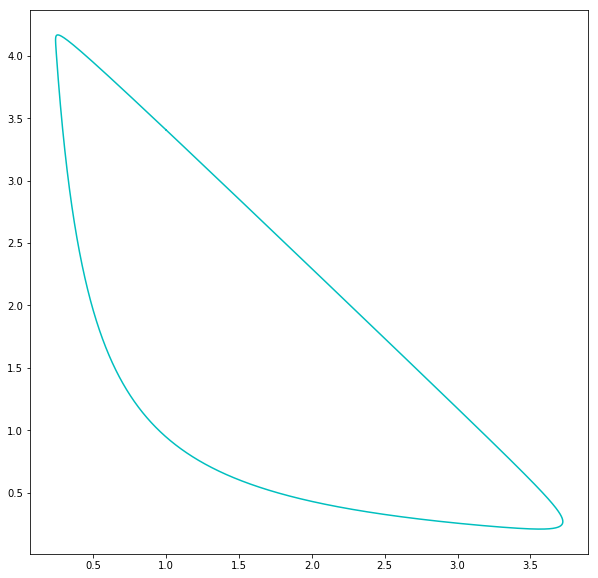

In [33]:
p_buf = p
q_buf = q
p = 1.13332996102
q = 0.1
Step = 0.0001
crv = find_cycle(0.00001,10000000)
print(crv[0][123])
plt.plot(crv[0],crv[1],'c')
plt.show()
p = p_buf
q = q_buf

In [ ]:
q=0.1
noise_lvl = 0.00001
Step = 0.00001
for k in range(1,2):
    p=1.13333
    print("P = "+str(p))
    cycl = find_cycle(0.00001,10000000)
    res = get_dp(cycl)
    minus = res['minus']
    plus = res['plus']

    plt.plot(plus[0],plus[1],c='m', lw=3)
    plt.plot(minus[0],minus[1],c='m' ,lw=3)
    plt.plеot(cycl[0],cycl[1],c='r',lw=2)
    plt.show()
    plt.plot([i*0.001 for i in range(0,len(res['ms']))],res['ms'])
    plt.show()

P = 1.13333
i am c


In [ ]:
q=1
noise_lvl = 0.00001
Step = 0.001
for k in range(1,2):
    p=5
    print("P = "+str(p))
    cycl = find_cycle(0.001,100000)
    plt.plot(cycl[0],cycl[1],c='r',lw=2)
    plt.grid()
    plt.show()
    #res = get_dp(cycl)
    #minus = res['minus']
    #plus = res['plus']
    #plt.plot(plus[0],plus[1],c='m', lw=3)
    #plt.plot(minus[0],minus[1],c='m' ,lw=3)
    
    #plt.plot([i*0.001 for i in range(0,len(res['ms']))],res['ms'])
    #plt.grid()
    #plt.show()

P = 5
i am c
